<a href="https://colab.research.google.com/github/danlingzhou16/stat390/blob/Danling/Danling_STAT390_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
## libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression

# stats models
import statsmodels.formula.api as smf
import time as time

In [68]:
df = pd.read_csv('/content/complete_top_10_imputation_rvsd.csv')

In [69]:
df

,Unnamed: 0,new_deceased,population,population_male,population_female,latitude,longitude,area_sq_km,life_expectancy,mobility_workplaces,gdp_usd,gdp_per_capita_usd,AG.LND.AGRI.K2,AG.LND.AGRI.ZS,AG.LND.ARBL.HA,AG.LND.ARBL.HA.PC,AG.LND.ARBL.ZS,AG.LND.CROP.ZS,AG.LND.FRST.K2,AG.LND.FRST.ZS,AG.LND.TOTL.K2,AG.PRD.CROP.XD,AG.PRD.FOOD.XD,AG.PRD.LVSK.XD,AG.SRF.TOTL.K2,BX.KLT.DINV.CD.WD,EG.ELC.ACCS.RU.ZS,EG.ELC.ACCS.UR.ZS,EG.ELC.ACCS.ZS,EG.ELC.RNEW.ZS,EG.FEC.RNEW.ZS,EN.ATM.CO2E.GF.KT,EN.ATM.CO2E.GF.ZS,EN.ATM.CO2E.KT,EN.ATM.CO2E.LF.KT,EN.ATM.CO2E.LF.ZS,EN.ATM.CO2E.PC,EN.ATM.CO2E.SF.KT,EN.ATM.CO2E.SF.ZS,EN.ATM.PM25.MC.M3,...,TM.VAL.MRCH.WL.CD,TM.VAL.MRCH.XD.WD,TT.PRI.MRCH.XD.WD,TX.QTY.MRCH.XD.WD,TX.UVI.MRCH.XD.WD,TX.VAL.MRCH.AL.ZS,TX.VAL.MRCH.CD.WT,TX.VAL.MRCH.HI.ZS,TX.VAL.MRCH.OR.ZS,TX.VAL.MRCH.R1.ZS,TX.VAL.MRCH.R2.ZS,TX.VAL.MRCH.R3.ZS,TX.VAL.MRCH.R4.ZS,TX.VAL.MRCH.R5.ZS,TX.VAL.MRCH.R6.ZS,TX.VAL.MRCH.RS.ZS,TX.VAL.MRCH.WL.CD,TX.VAL.MRCH.XD.WD,new_confirmed,date,location_key_x,country_code,country_name,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,school_closing,workplace_closing,cancel_public_events,restrictions_on_gatherings,public_transport_closing,stay_at_home_requirements,restrictions_on_internal_movement,international_travel_controls,income_support,debt_relief,public_information_campaigns,contact_tracing,testing_policy,facial_coverings,vaccination_policy
0,0,0.0,733391.0,424916.0,391925.0,64.0,-150.0,1717856.0,78.0,-10.333333,2.137442e+13,65118.0,4058625.0,44.369068,152262500.0,0.471487,16.645404,0.284233,3103700.0,33.929786,9147420.0,122.19,122.32,109.70,9831510.0,3.108110e+11,100.0,100.0,100.0,13.228593,8.716936,1498556.220,29.933396,5006302.077,2127054.351,42.487535,15.502204,1323423.967,26.435160,7.409442,...,2.542730e+12,207.446931,99.842644,167.899761,126.900000,3.602897,1.645625e+12,60.160159,39.701735,10.447935,1.398441,23.603533,0.908951,2.398344,0.944532,0.138105,1.664240e+12,213.064797,0.0,2020-01-22,US_AK,US,United States of America,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
1,1,0.0,733391.0,424916.0,391925.0,64.0,-150.0,1717856.0,78.0,-10.333333,2.137442e+13,65118.0,4058625.0,44.369068,152262500.0,0.471487,16.645404,0.284233,3103700.0,33.929786,9147420.0,122.19,122.32,109.70,9831510.0,3.108110e+11,100.0,100.0,100.0,13.228593,8.716936,1498556.220,29.933396,5006302.077,2127054.351,42.487535,15.502204,1323423.967,26.435160,7.409442,...,2.542730e+12,207.446931,99.842644,167.899761,126.900000,3.602897,1.645625e+12,60.160159,39.701735,10.447935,1.398441,23.603533,0.908951,2.398344,0.944532,0.138105,1.664240e+12,213.064797,0.0,2020-01-23,US_AK,US,United States of America,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
2,2,0.0,733391.0,424916.0,391925.0,64.0,-150.0,1717856.0,78.0,-10.333333,2.137442e+13,65118.0,4058625.0,44.369068,152262500.0,0.471487,16.645404,0.284233,3103700.0,33.929786,9147420.0,122.19,122.32,109.70,9831510.0,3.108110e+11,100.0,100.0,100.0,13.228593,8.716936,1498556.220,29.933396,5006302.077,2127054.351,42.487535,15.502204,1323423.967,26.435160,7.409442,...,2.542730e+12,207.446931,99.842644,167.899761,126.900000,3.602897,1.645625e+12,60.160159,39.701735,10.447935,1.398441,23.603533,0.908951,2.398344,0.944532,0.138105,1.664240e+12,213.064797,0.0,2020-01-24,US_AK,US,United States of America,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
3,3,0.0,733391.0,424916.0,391925.0,64.0,-150.0,1717856.0,78.0,-10.333333,2.137442e+13,65118.0,4058625.0,44.369068,152262500.0,0.471487,16.645404,0.284233,3103700.0,33.929786,9147420.0,122.19,122.32,109.70,9831510.0,3.108110e+11,100.0,100.0,100.0,13.228593,8.716936,1498556.220,29.933396,5006302.077,2127054.351,42.487535,15.502204,1323423.967,26.435160,7.409442,...,2.542730e+12,207.446931,99.842644,167.899761,126.900000,3.602897,1.645625e+12,60.160159,39.701735,10.447935,1.398441,23.603533,0.908951,2.398344,0.944532,0.138105,1.664240e+12,213.064797,0.0,2020-01-25,US_AK,US,United States of America,

In [73]:
train = df.loc[df.date < '2022-01-01']
test = df.loc[df.date >= '2022-01-01']

In [98]:
X_train = train.drop(columns = ['Unnamed: 0', 'date','new_confirmed','country_name'])
y_train = train.new_confirmed
X_test = test.drop(columns = ['Unnamed: 0', 'date','new_confirmed','country_name'])
y_test = test.new_confirmed

In [109]:
# the notation . does not work in smf formula
X_train_slct = pd.concat([X_train.iloc[:,0:11],X_train.iloc[:,159:]], axis = 1)
X_test_slct = pd.concat([X_test.iloc[:,0:11],X_test.iloc[:,159:]], axis = 1)

In [110]:
# needs dummy variables for the country
X_train_slct_dum = pd.get_dummies(X_train_slct, drop_first = True)
X_test_slct_dum = pd.get_dummies(X_test_slct, drop_first = True)
#add back the dummy X_train back to the y_train
train_modidied = pd.concat([X_train_slct_dum, y_train], axis = 1)
test_modidied = pd.concat([X_test_slct_dum, y_test], axis = 1)

In [115]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = smf.ols('new_confirmed~' + '+'.join(predictor_subset),data = train_modidied).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}

In [116]:
# select variables for linear regression
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):
    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X_train_slct_dum.columns if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    # Return the best model, along with some other useful information about the model
    return best_model

In [117]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X_train_slct_dum.columns)+1):
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [118]:
models_best = forward_selection()

Processed  37 models on 1 predictors in 1.1279032230377197 seconds.
Processed  36 models on 2 predictors in 1.379324197769165 seconds.
Processed  35 models on 3 predictors in 1.5942459106445312 seconds.
Processed  34 models on 4 predictors in 1.7901983261108398 seconds.
Processed  33 models on 5 predictors in 2.0154917240142822 seconds.
Processed  32 models on 6 predictors in 2.262627124786377 seconds.
Processed  31 models on 7 predictors in 2.450639009475708 seconds.
Processed  30 models on 8 predictors in 2.533597707748413 seconds.
Processed  29 models on 9 predictors in 2.7449562549591064 seconds.
Processed  28 models on 10 predictors in 2.8650760650634766 seconds.
Processed  27 models on 11 predictors in 2.93513822555542 seconds.
Processed  26 models on 12 predictors in 2.9869704246520996 seconds.
Processed  25 models on 13 predictors in 3.005828380584717 seconds.
Processed  24 models on 14 predictors in 3.0421934127807617 seconds.
Processed  23 models on 15 predictors in 2.9723253

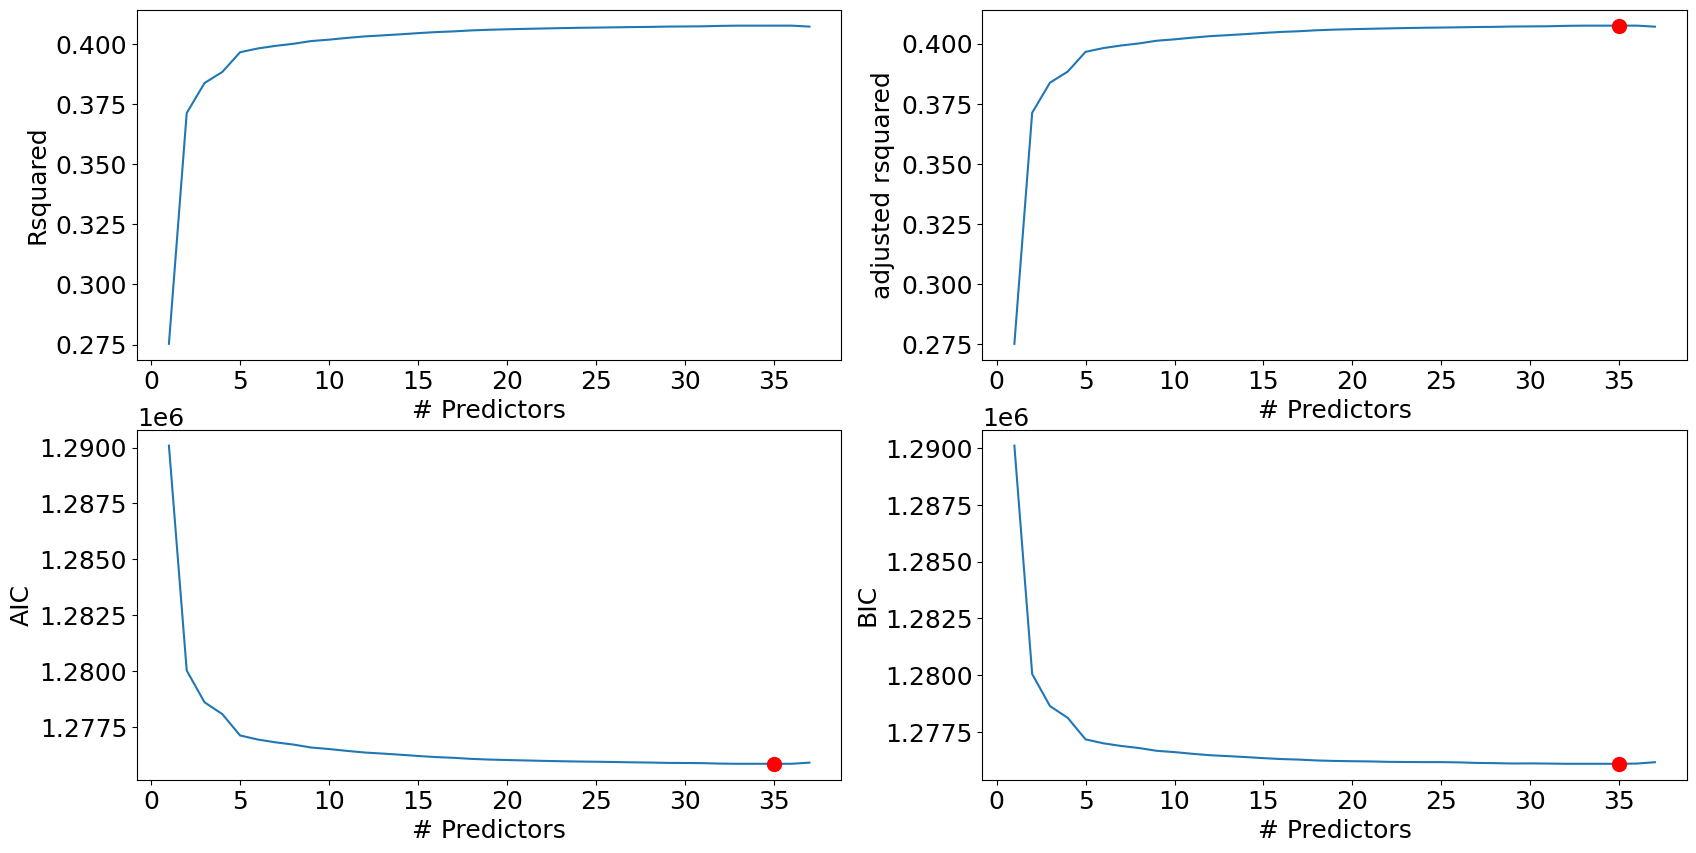

In [120]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

In [121]:
best_subset_model = models_best.loc[35,'model']
models_best.loc[35,'model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          new_confirmed   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     1875.
Date:                Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                        00:17:39   Log-Likelihood:            -6.3789e+05
No. Observations:               70829   AIC:                         1.276e+06
Df Residuals:                   70802   BIC:                         1.276e+06
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                           -1945.4007    219.649     -8.857      0.000   -2375.913   -1514.888
new_deceased                           20.4871      0.196    104.484      0.000      20.103      20.871
population_female                       0.0004      0.000      2.741      0.006       0.000       0.001
cumulative_persons_fully_vaccinated     0.0002   5.44e-06     28.634      0.000       0.000       0.000
facial_coverings                      248.2549     13.667     18.164      0.000     221.467     275.043
income_support                       -434.4240     18.484    -23.503      0.000    -470.652    -398.196
mobility_workplaces                    -6.8953      0.495    -13.923      0.000      -7.866      -5.925
new_persons_fully_vaccinated           -0.0021      0.000    -10.915      0.000      -0.003      -0.002
gdp_usd                              9.076e-12   3.13e-12      2.898      0.004    2.94e-12    1.52e-11
country_code_SG                      -348.8782    122.158     -2.856      0.004    -588.307    -109.449
testing_policy                        186.3975     19.779      9.424      0.000     147.631     225.164
stay_at_home_requirements             242.1667     24.421      9.916      0.000     194.301     290.032
debt_relief                          -194.2844     19.188    -10.125      0.000    -231.893    -156.676
country_code_IE                      1600.0701    124.163     12.887      0.000    1356.710    1843.430
longitude                               2.3248      0.237      9.801      0.000       1.860       2.790
public_transport_closing             -147.2581     19.225     -7.660      0.000    -184.939    -109.577
vaccination_policy                    -49.2624      6.995     -7.042      0.000     -62.973     -35.552
international_travel_controls         187.6884     20.017      9.377      0.000     148.455     226.921
area_sq_km                              0.0001      4e-05      2.519      0.012    2.23e-05       0.000
public_information_campaigns         -137.4917     43.666     -3.149      0.002    -223.076     -51.907
country_code_IS                      1503.2582    159.516      9.424      0.000    1190.607    1815.909
cancel_public_events                 -100.6458     23.541     -4.275      0.000    -146.786     -54.506
country_code_CH                       951.1818    113.062      8.413      0.000     729.581    1172.783
restrictions_on_gatherings             46.8106      9.617      4.867      0.000      27.961      65.660
country_code_NO                      1091.9400    143.749      7.596      0.000     810.192    1373.688
country_code_DK                      1277.0618    159.192      8.022      0.000     965.046    1589.077
contact_tracing                        72.9357     21.245      3.43

In [127]:
y_fit = best_subset_model.predict(X_train_slct_dum)
print('The RMSE on the training data is', mean_squared_error(y_train, y_fit, squared = False))

The RMSE on the training data is 1972.7229072153907


In [128]:
y_pred = best_subset_model.predict(X_test_slct_dum)
print('The RMSE on the testing data is', mean_squared_error(y_test, y_pred, squared = False))

The RMSE on the testing data is 6422.658905968989


The simple linear model is not accurate and overfits a lot. Also statsmodels cannot column names with "." and spaces between characters. This model is not attempted any further.